In [53]:
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

import warnings
import random
import numpy as np
import scipy
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn_image as isns

sns.set_style("darkgrid")
isns.set_image(origin="upper")

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = Path(self.img_labels.iloc[idx]["file_path"])
        image = read_image(str(img_path))
        label = self.img_labels.iloc[idx]["class_index"]
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label


In [18]:
label_names = {0: "tree", 1:"sun", 2:"fish", 3:"bird", 4:"flower"}

In [19]:
train_dataset = CustomImageDataset("./data/train_data.csv")
test_dataset = CustomImageDataset("./data/test_data.csv")

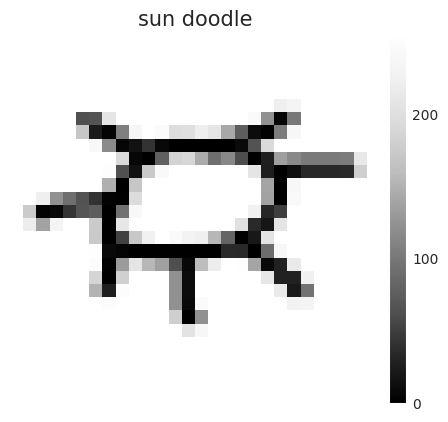

In [23]:
sample_image = random.choice(train_dataset)

ax = isns.imgplot(sample_image[0][0,:,:], cmap="Greys_r")
ax.set_title(f"{label_names[sample_image[1]]} doodle")
plt.show()

In [24]:
input_train_matrix = np.empty((len(train_dataset),) + train_dataset[0][0].shape[1:])
input_test_matrix = np.empty((len(test_dataset),) + test_dataset[0][0].shape[1:])

target_train_matrix = np.empty(len(train_dataset))
target_test_matrix = np.empty(len(test_dataset))


for idx, data_point in enumerate(train_dataset):
    input_train_matrix[idx] = data_point[0][0,:,:]
    target_train_matrix[idx] = data_point[1]

for idx, data_point in enumerate(test_dataset):
    input_test_matrix[idx] = data_point[0][0,:,:]
    target_test_matrix[idx] = data_point[1]


input_train_matrix = input_train_matrix.reshape([input_train_matrix.shape[0], -1])
input_test_matrix = input_test_matrix.reshape([input_test_matrix.shape[0], -1])

print(input_train_matrix.shape)
print(input_test_matrix.shape)
print(target_train_matrix.shape)
print(target_test_matrix.shape)

(12000, 784)
(3000, 784)
(12000,)
(3000,)


(28, 28)


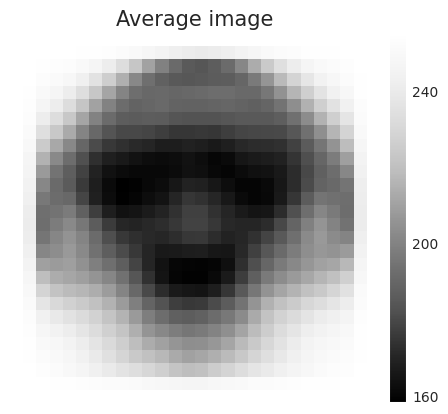

In [31]:
avgimg = np.mean(input_train_matrix, axis=0).reshape([28,28])
print(avgimg.shape)
mean_ax = isns.imgplot(avgimg, cmap="Greys_r")
mean_ax.set(title="Average image")
plt.show()

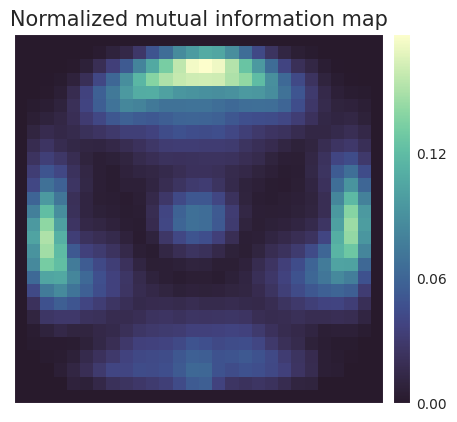

In [58]:
r = np.empty(input_train_matrix.shape[1:])


discretizer = KBinsDiscretizer(n_bins=64, encode='ordinal')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    input_train_matrix_disc = discretizer.fit_transform(input_train_matrix)


for idx, val in enumerate(input_train_matrix[0]):
    
    x = input_train_matrix_disc[:, idx]
    y = target_train_matrix

    r[idx] = normalized_mutual_info_score(x, y)
    

mutinfo_ax = isns.imgplot(r.reshape([28,28]), cmap="deep")
mutinfo_ax.set(title="Normalized mutual information map")
plt.show()

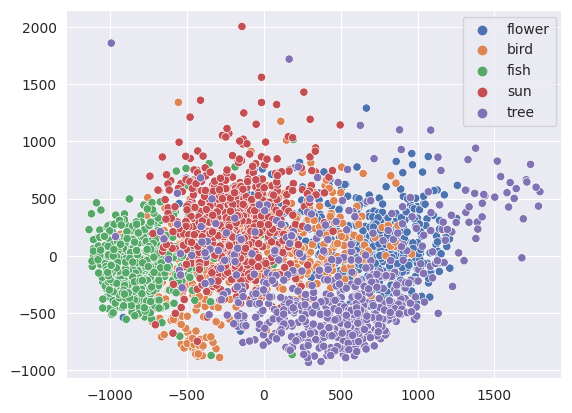

In [59]:
pca = PCA(n_components=2)
pca.fit(input_train_matrix)

test_reduced = pca.transform(input_test_matrix)

sns.scatterplot(x=test_reduced[:,0], y=test_reduced[:,1], hue=map(label_names.__getitem__, target_test_matrix), palette="deep")
plt.show()